### Init

This is a brief demo of the Pig (dice game) software package.
See the [Wiki page](https://en.wikipedia.org/wiki/Pig_%28dice_game%29) for the rules.
First, load the software:

In [1]:
master_file = open("./pig_master.py")
exec(master_file.read())
master_file.close()
import os

### Pig players

Next, we define Pig players. There are three strategies:
-  <code>strategy='learn'</code> $\rightarrow$ learn, i.e. make future decisions based on past decisions; parameter: <code>learn_from</code>, a list of sources to learn from
-  <code>strategy='hold'</code> $\rightarrow$ hold at a specified integer; parameter: <code>hold_at</code>
-  <code>strategy='random'</code> $\rightarrow$ decide randomly whether or not to hold; parameter: <code>hold_p</code>

Consider the following example.

In [2]:
a = PigPlayer(name='Alice', write_to='A_demo_dec', strategy = 'learn', learn_from=['A_demo_dec', 'B_demo_dec'])
print(a)

Player: Alice
Data written to: A_demo_dec
Strategy: Learn from the following sources.
 A_demo_dec B_demo_dec


In [3]:
b = PigPlayer(name='Bob', write_to='B_demo_dec', strategy = 'random', hold_p=1)
print(b)

Player: Bob
Data written to: B_demo_dec
Strategy: Random with probability 1.0.


### Pig tournament

A Pig tournament is a sequence of Pig games. It is initialised as follows.

In [4]:
t = PigTournament(a, b)

We first delete old player data, so that Alice starts learning from scratch and we can see her improvement over the course of the tournament.

In [5]:
if os.path.isfile('./player_data/A_demo_dec.p'):
    os.remove('./player_data/A_demo_dec.p')
if os.path.isfile('./player_data/B_demo_dec.p'):
    os.remove('./player_data/B_demo_dec.p')

Running <code>play_games()</code> will simulate <code>n</code> (default 100) games. Here, all decisions and whether or not the lead to victory are recorded after each game, and Alice will base future decisions on that experience.

In [6]:
t.play_games(n=10)
print(t)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


Alice (5 wins) : (5 wins) Bob


In [7]:
t.play_games(n=190)
print(t)

HBox(children=(IntProgress(value=0, max=190), HTML(value='')))


Alice (84 wins) : (16 wins) Bob


In [8]:
t.play_games(n=800)
print(t)

HBox(children=(IntProgress(value=0, max=800), HTML(value='')))


Alice (95 wins) : (5 wins) Bob


### Output

<code>PigPlayer</code> objects as well as <code>PigTournament</code>s have can be printed, where printing a tournament gives the score over the last 100 games. Furthermore, can produce the following plot (the sequence that is plotted there can be obtained via <code>results_as_sequence()</code>).

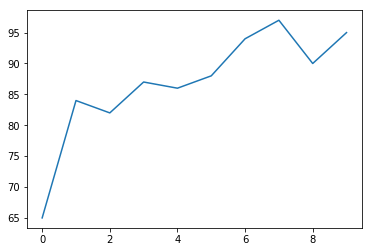

In [9]:
t.plot_results()

### Performance

The learning performance in the above example was very good -- the learner Alice progresses from a winning probability of about 60% to about 90% within two minutes. However, her opponent Bob was given a weak strategy here (this is the most conservative strategy -- Bob always holds and therefore builds up his score very slowly), and this makes it relatively easy for Alice to become dominant. The following graph shows the history of a tournament for which Bob was given the very strong <code>hold_at=25</code> strategy (50,000 iterations, approx 90 minutes; here, the number of wins are aggregated over 1,000 games).

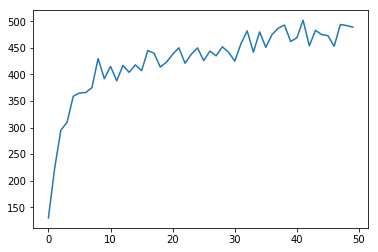

Alice's performance keeps improving slowly afterwards. Below are the next 800,000 iterations (history was reset, but the learning/gaining of experience is continued; here the number of wins are aggregated over 50,000, so 25,000 corresponds to 50%). Note that, since Bob was given a very good strategy, we can't expect Alice's winning probability to go much beyond 50% (E.g., if Bob had the optimal strategy -- cf. the 'grey solid' on the Wiki page -- then Alice could reach at most 50%).

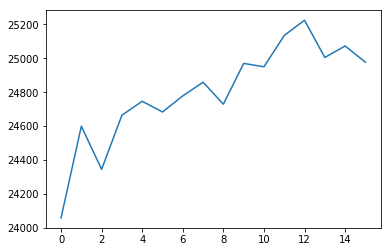

Is Alice catching up with Bob? Or is she even starting to dominate him? The following graph shows her performance over the next 350,000 iterations (aggregated over 10,000 again).

To-do: run 150K more simulations and then insert the graph here.

### The learning algorithm

The task to be learned is to decide whether to continue a turn or to hold. The decision depends only on the player's score, the opponent's score, and the current turn total (cf. the Wiki page). This gives a small parameter space for the function that makes the decision -- its size is $100 \times 100 \times 100$. Hence, instead of using machine learning algorithms, the decisions that have been made in a game are recorded in a matrix once the game is concluded. This happens by simply increasing counters, and it has the advantage that the space complexity for the algorithm is constant. The matrix is of size $100 \times 100 \times 100 \times 2 \times 2$. If in a subsequent game, Alice has to make a decision for a certain situation <code>own_score</code>, <code>opp_score</code>, <code>turn_total</code> (first three dimesions), then the corresponding $2 \times 2$ matrix (last two dimensions) shows her how often continue/hold decisions have lead to wins/losses in the past. She can then make her decision based on that.

### Remarks

1. This is not a polished project -- no docstrings etc available; please refer to the code. Also, this has not been tested very much and the decision algorithm can be improved.
2. The structure of Pig players that are learners ('Alice' in the following) -- a <code>write_to</code> argument and a <code>learn_from</code> list -- is meant to provide flexibility. For example, Alice could learn only from her own decisions, only from the opponent's decisions, or from both. Moreover she could further use an old file of decisions as input or learn from observing other players etc. Most importantly, she could built up her experience by playing Pig players with different strategies. When restarting the notebook or beginning a tournament with a new opponent, the tournament history will be reset, but unless the player data files are deleted or renamed, experiences is built up continuously (when using a number of different files for a learner, or old ones, one can roughly estimate how much experience they contain by calling <code>get_approx_experience()</code> on the player object). 
3. Note that allows for a lot of exploring: one can let learners play against each other, define a larger group of players with different learning or non-learning strategies, let a learner observe two players with good strategies (e.g. hold at 25 vs hold at 20), etc.
4. The disadvantage of the structure mentioned point 2 is that this way, there is quite a lot of writing to / reading from disk. The impact of this was reduced by using virtual file systems within an execution of <code>play_games()</code> -- reading from / writing to disk now only happens at the beginning and end of that method, rather than for each individual game (this reduced time complexity by a factor of 3).
5. Running <code>play_game()</code> simulates a single game with detailed output of intermediate scores, see below.
6. One can also visualise the decision matrix of a player (cf. the 'grey solid' on the Wiki page). This is done below for the player Alice from the section 'Performance' above (i.e. after learning from 1,000,000 games against a hold_at_25 player).

In [10]:
t.play_game()

0 : 0
Turn: 0
Roll: 5
Decided to hold.
0 : 5
Turn: 0
Roll: 4
Turn: 4
Roll: 1
Kicked out.
0 : 5
Turn: 0
Roll: 3
Decided to hold.
0 : 8
Turn: 0
Roll: 1
Kicked out.
0 : 8
Turn: 0
Roll: 4
Decided to hold.
0 : 12
Turn: 0
Roll: 1
Kicked out.
0 : 12
Turn: 0
Roll: 1
Kicked out.
0 : 12
Turn: 0
Roll: 1
Kicked out.
0 : 12
Turn: 0
Roll: 5
Decided to hold.
0 : 17
Turn: 0
Roll: 3
Turn: 3
Roll: 2
Turn: 5
Roll: 5
Decided to hold.
10 : 17
Turn: 0
Roll: 3
Decided to hold.
10 : 20
Turn: 0
Roll: 2
Turn: 2
Roll: 4
Turn: 6
Roll: 3
Decided to hold.
19 : 20
Turn: 0
Roll: 2
Decided to hold.
19 : 22
Turn: 0
Roll: 4
Decided to hold.
23 : 22
Turn: 0
Roll: 2
Decided to hold.
23 : 24
Turn: 0
Roll: 3
Turn: 3
Roll: 5
Decided to hold.
31 : 24
Turn: 0
Roll: 3
Decided to hold.
31 : 27
Turn: 0
Roll: 6
Decided to hold.
37 : 27
Turn: 0
Roll: 3
Decided to hold.
37 : 30
Turn: 0
Roll: 2
Decided to hold.
39 : 30
Turn: 0
Roll: 4
Decided to hold.
39 : 34
Turn: 0
Roll: 2
Decided to hold.
41 : 34
Turn: 0
Roll: 4
Decided to hold.
4

[True]

In [11]:
# to-do: visualise Alice's decision matrix once this has been implemented